# Model Error Pipeline

## Introduction

The purpose of this notebook is to examine the traces for which the model performed worse. In particular, consider the 10dB dataset generated using ETHZ and Joachim Noises and look at the traces where the pretrained model performed worse than a second away.

## Preparations - Imports, Config, Data and model loading etc.

In [1]:
# seisbench
import seisbench.models as sbm
#plotting
#torch - computing and machine learning libraries
# seisynth
from dataset_creation.utils import search_large_errors_given_desired_snr, create_noisy_traces, get_n_random_noises
from experiments.filtering import fft_filter_experiment
from snr.calc_snr import CalcSNR, SnrCalcStrategy
from experiments.shifting import shifting_experiment
from utils.common import load_dataset_and_labels, load_pretrained_model

In [2]:
NUM_SAMPLES=3001
NUM_SHIFTS=5
SAMPLE_RATE=100
SYNTHESIZED_SNR=10
SHIFTING_PLOTS_PATH='/home/moshe/GIT/summer_2022_Seismology/notebooks/shifting_plots'
DATA_PATH='./noisy_datasets/ethz_3001_sample_joachim_noises_energy_ratio_snr/'
NOISES_DATSET_PT='noises_dataset.pt'
NOISES_PATH='/home/moshe/GIT/summer_2022_Seismology/notebooks/Noises'

### Load a "Natural" Dataset

Load a dataset of high SNR traces taken from the ETHZ dataset.
The term *natural* states that these are real events and not synthetic data.

In [3]:
natural_dataset, natural_dataset_labels = load_dataset_and_labels(dataset_path=DATA_PATH + 'original_dataset.pt', labels_path=DATA_PATH + 'original_labels.pt')
assert NUM_SAMPLES == natural_dataset.shape[-1], f'Expected Dataset contain {NUM_SAMPLES} samples. Got {natural_dataset.shape[-1]}'

print(f'The loaded dataset has {natural_dataset.shape[0]} traces, each has {natural_dataset.shape[1]} channels of {natural_dataset.shape[2]} samples. Each entry is of type {natural_dataset.dtype}')

print(f'The loaded labels has {natural_dataset_labels.shape[0]} labels. Each entry is of type {natural_dataset_labels.dtype}')

num_traces = natural_dataset.shape[0]

The loaded dataset has 571 traces, each has 3 channels of 3001 samples. Each entry is of type torch.float32
The loaded labels has 571 labels. Each entry is of type torch.float64


### Load a Pretrained Phasenet Model

In [4]:
pretrained_model = load_pretrained_model(model_class=sbm.PhaseNet, dataset_trained_on='ethz')
pretrained_model.eval()

Working with phasenet on ETHZ
Load <class 'seisbench.models.phasenet.PhaseNet'> pretrained weights
<class 'seisbench.models.phasenet.PhaseNet'> pretrained keys ['ethz', 'geofon', 'instance', 'iquique', 'lendb', 'neic', 'obs', 'scedc', 'stead']


PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(1,), stride=(1,))
  (in_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1dSame(
    (conv): Conv1d(8, 11, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd1): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1dSame(
    (conv): Conv1d(11, 16, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1dSame(
    (conv): Conv1d(16, 22, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd3): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1dSame(
    (conv): Conv1d(22, 32, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up1): ConvTranspose1d(32, 22, kernel_size=(7,), stride=(4,), padding=(2,))
  (bnu1): Batc

In [5]:
full_noise_traces = get_n_random_noises(num_noises=num_traces, desired_window_size=NUM_SAMPLES + NUM_SHIFTS * SAMPLE_RATE, noises_path=NOISES_PATH, filename=NOISES_DATSET_PT)

# Take the leftmost NUM_SAMPLES samples. The rest is left for shifts
noises=full_noise_traces[:,:NUM_SAMPLES]

full_noise_traces.shape, noises.shape

###/home/moshe/GIT/summer_2022_Seismology/notebooks/Noises/noises_dataset.pt


(torch.Size([571, 3501]), torch.Size([571, 3001]))

In [6]:
large_error_traces_index_list = search_large_errors_given_desired_snr(model=pretrained_model, dataset=natural_dataset, labels=natural_dataset_labels, noise_traces=noises, desired_snr=SYNTHESIZED_SNR, calc_snr=CalcSNR(SnrCalcStrategy.ENERGY_RATIO))


print(f'There are {len(large_error_traces_index_list)} large errors')

There are 21 large errors


## Shifting scheme for large error cases

In [7]:
le_dataset = natural_dataset[large_error_traces_index_list]
le_labels = natural_dataset_labels[large_error_traces_index_list]
le_noises_full = full_noise_traces[large_error_traces_index_list]

/home/moshe/GIT/summer_2022_Seismology/visualization/comparing_plots.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(num_traces, sharey='all', figsize=(8, num_traces * 2))


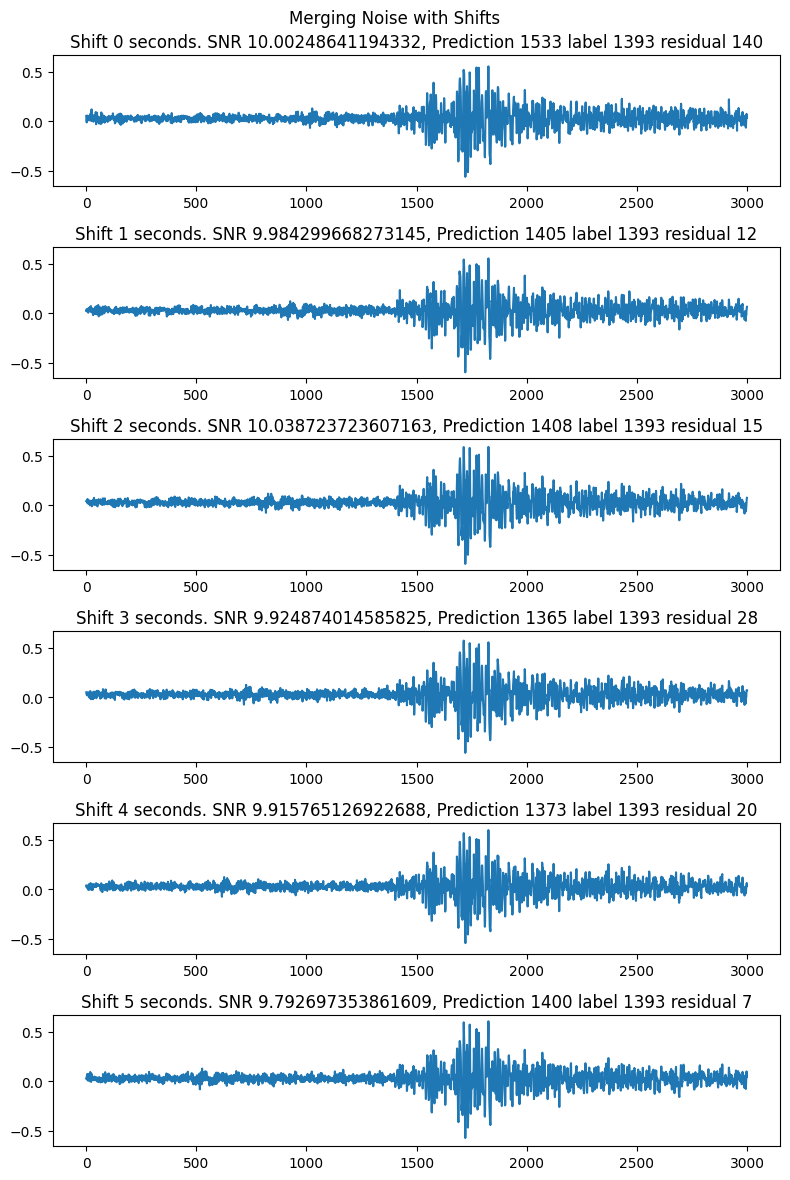

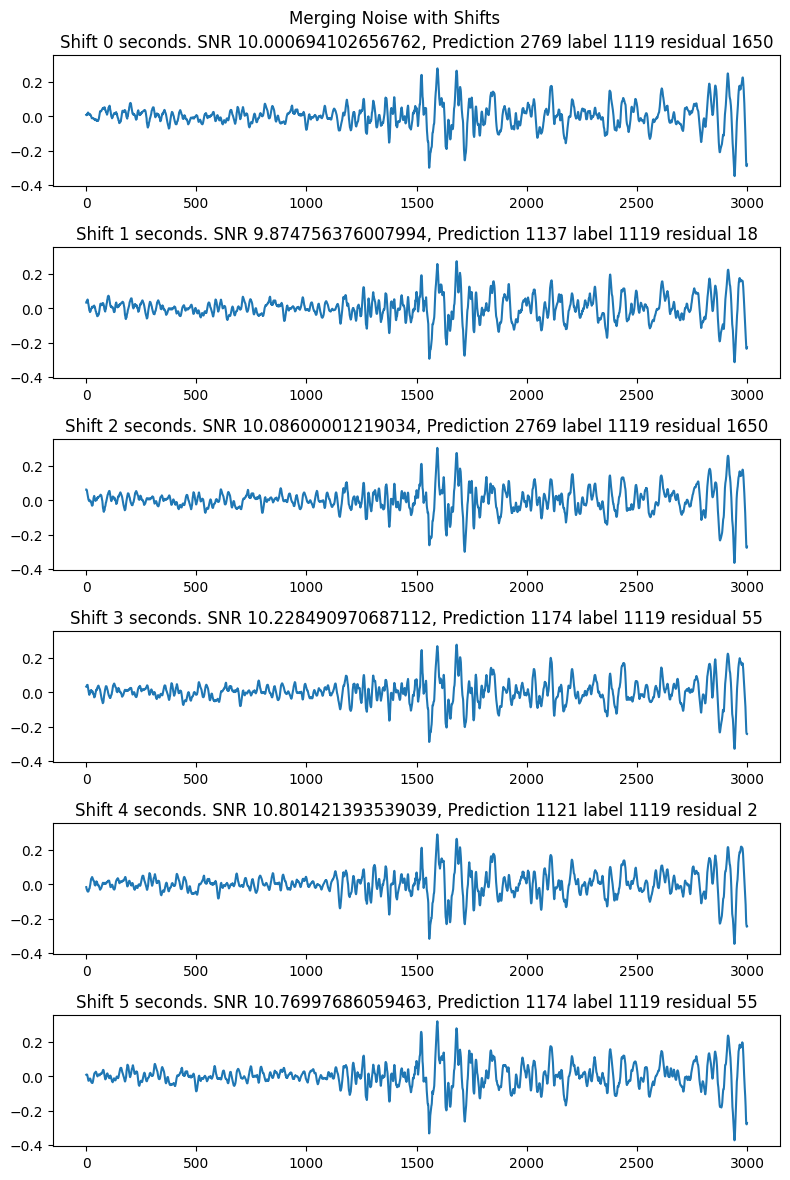

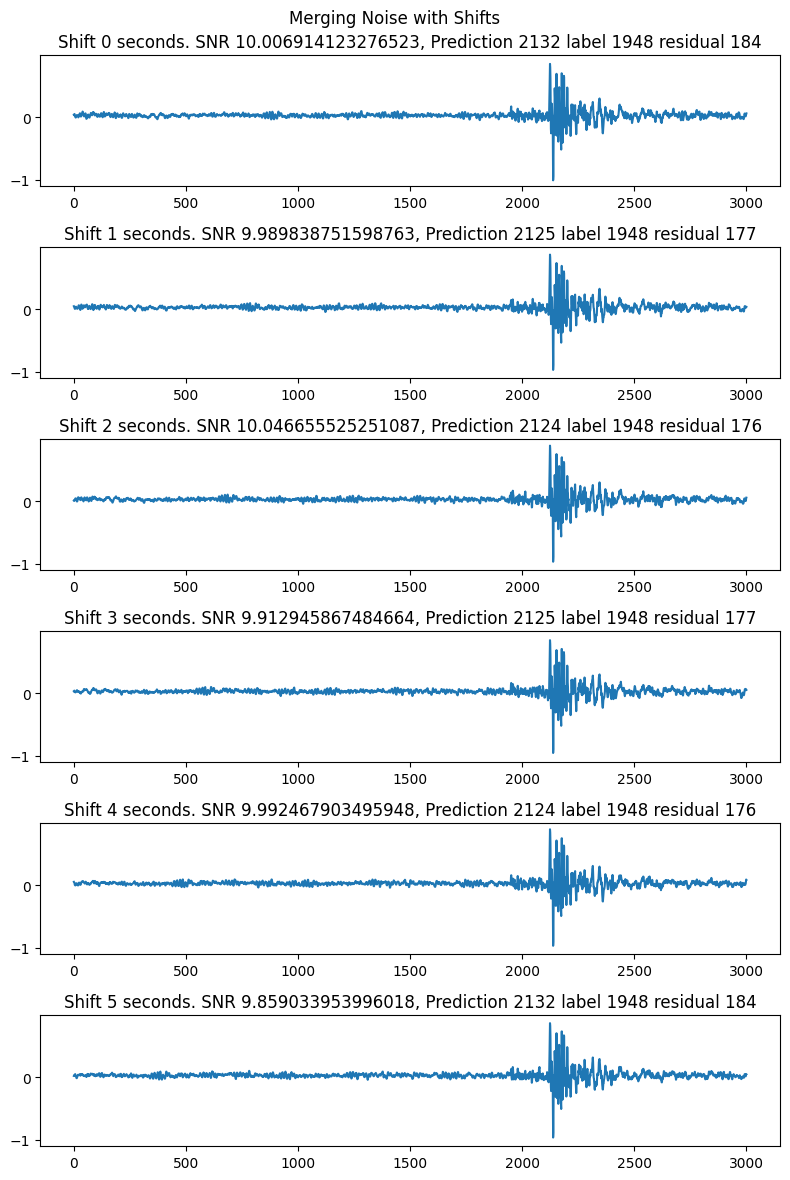

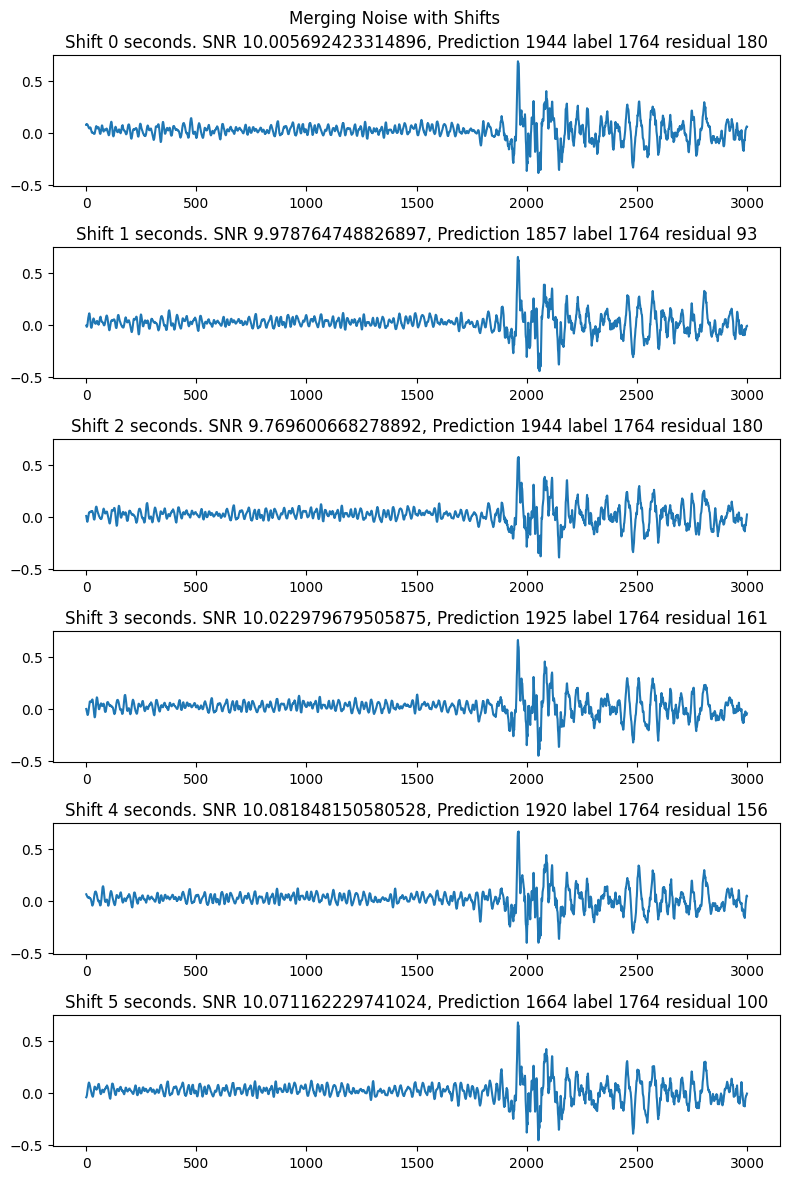

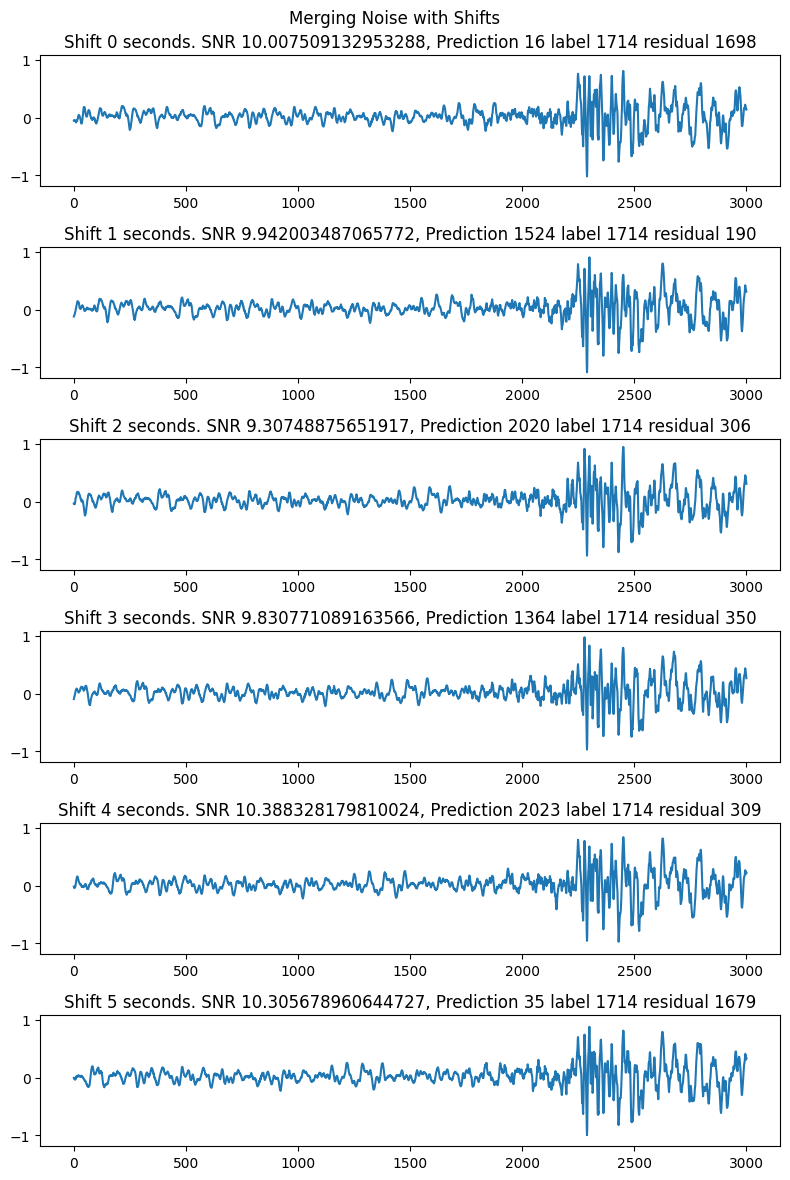

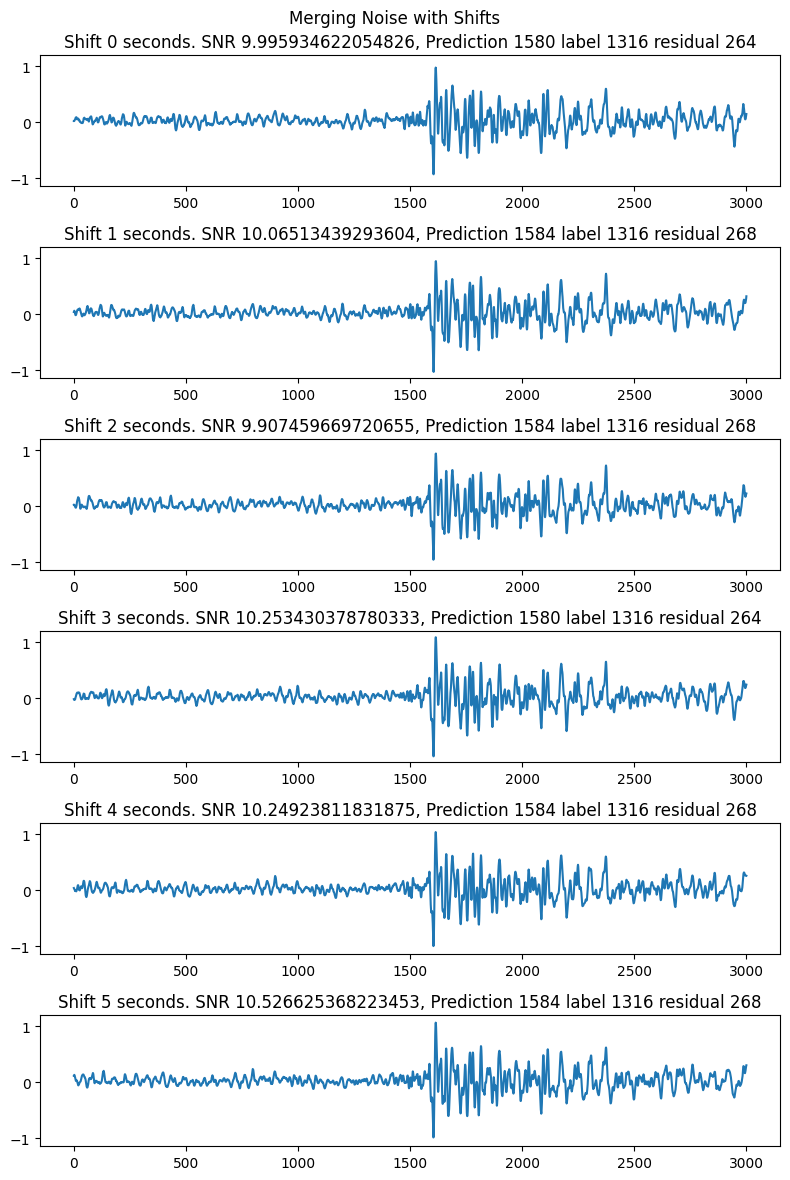

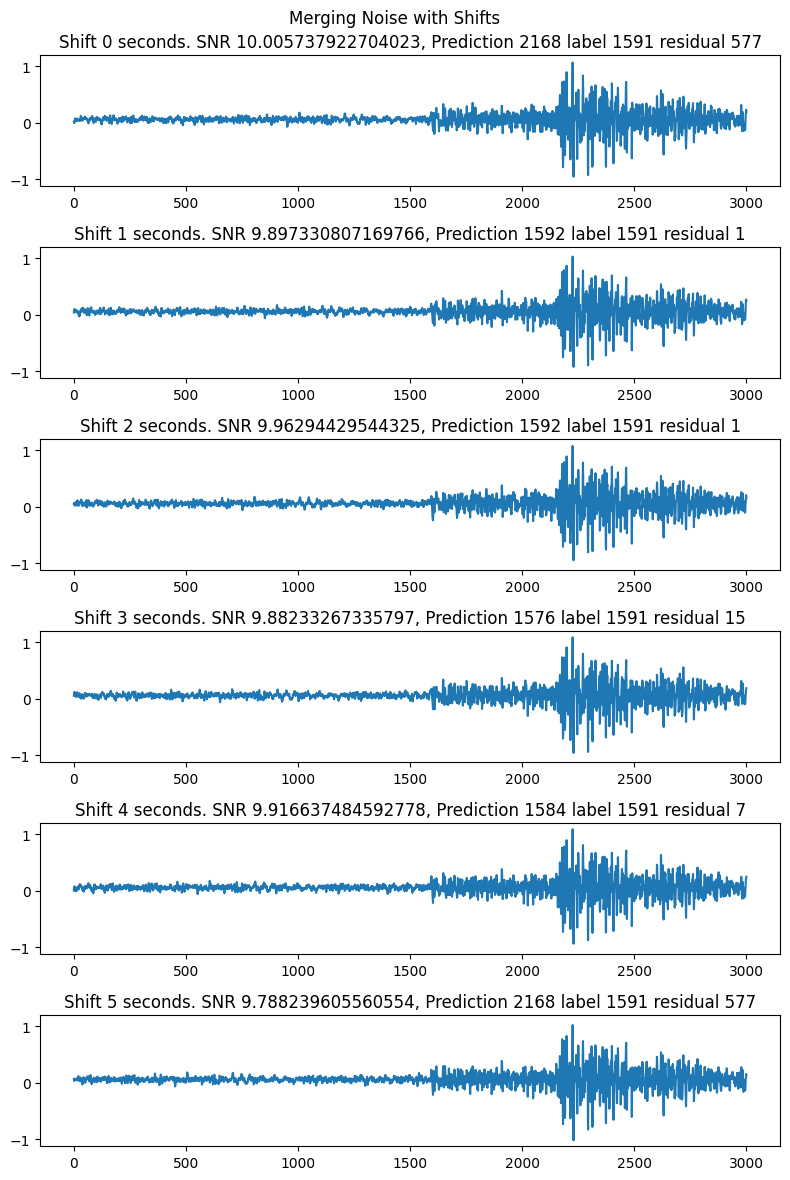

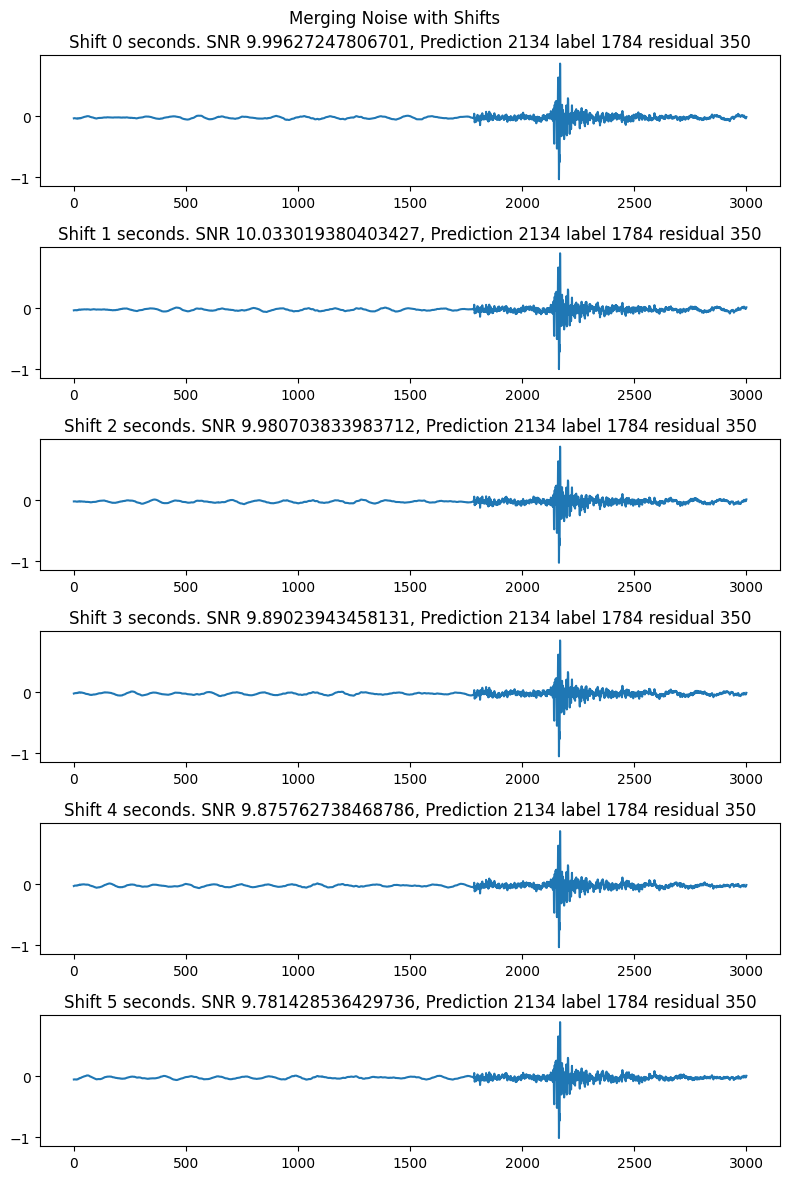

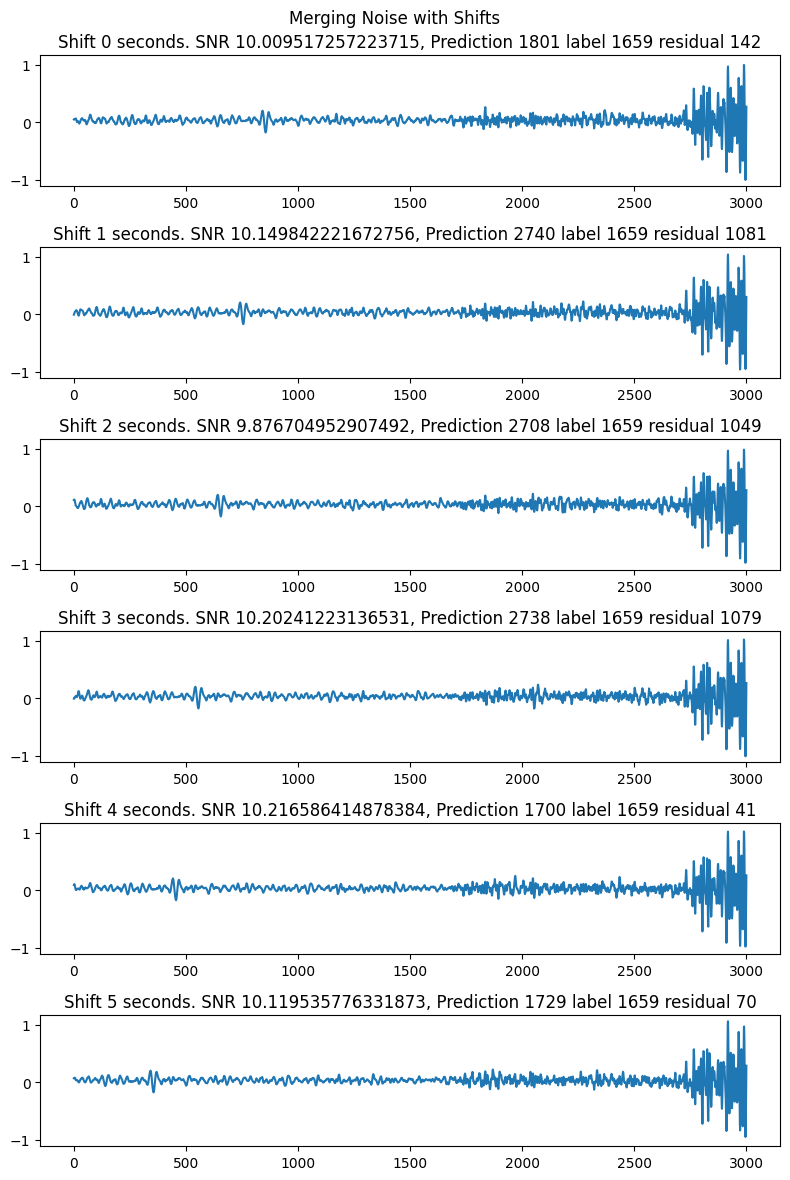

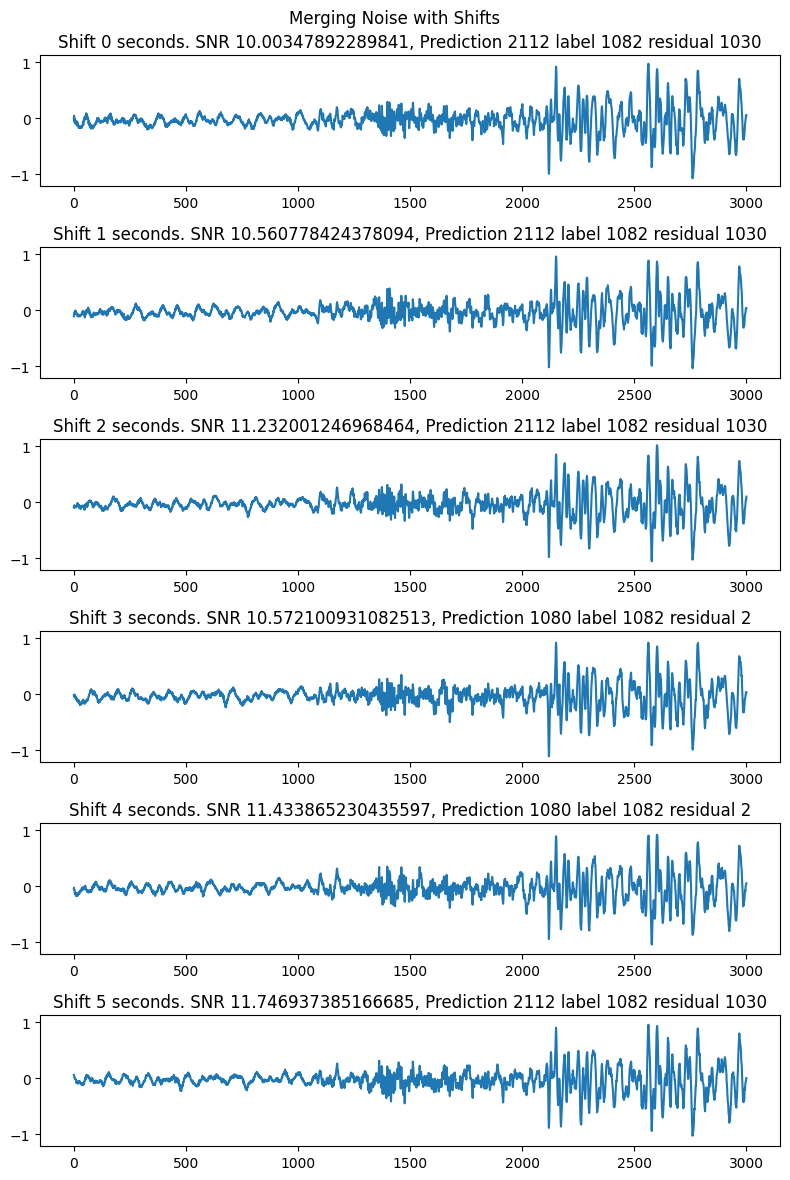

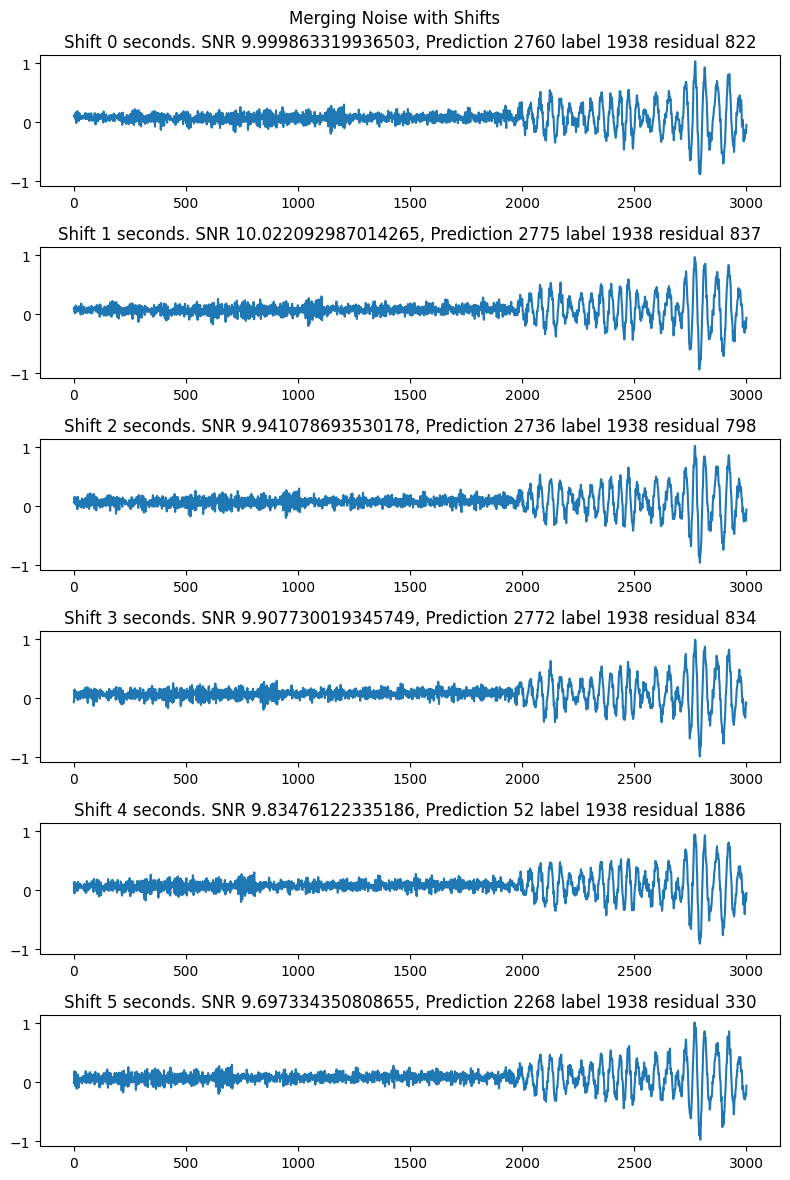

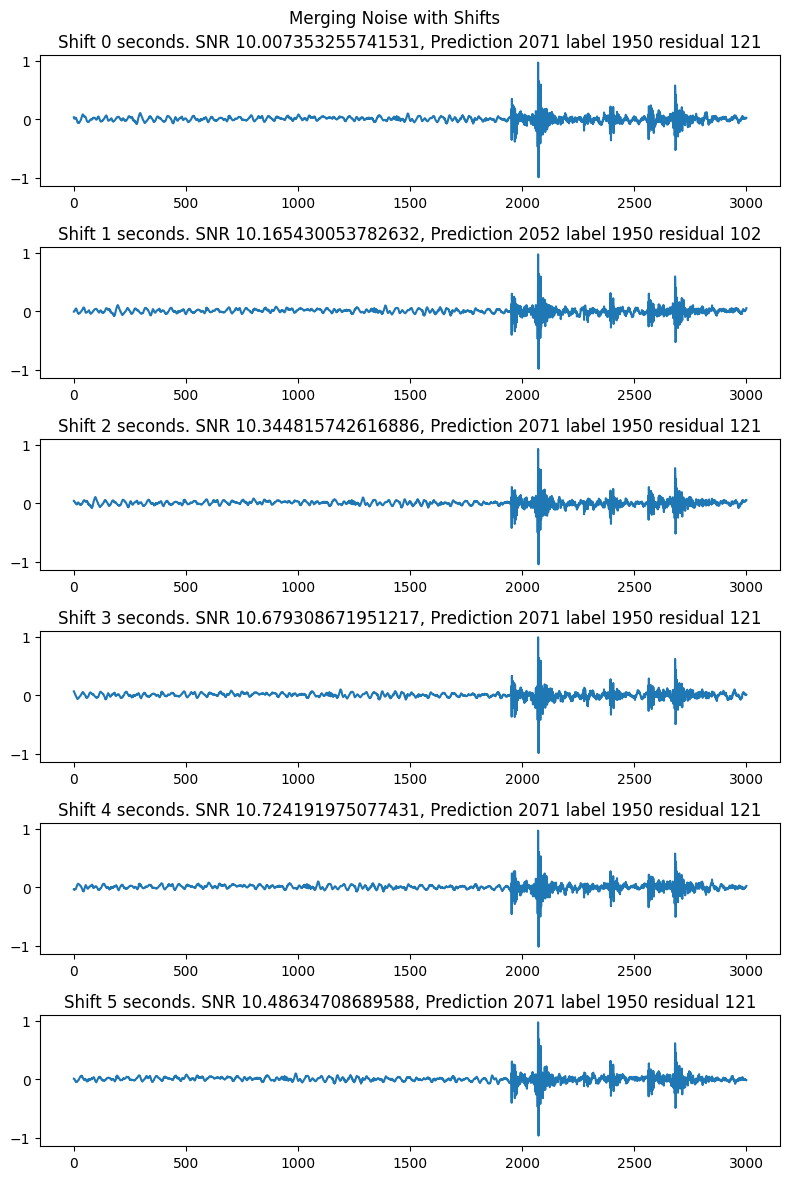

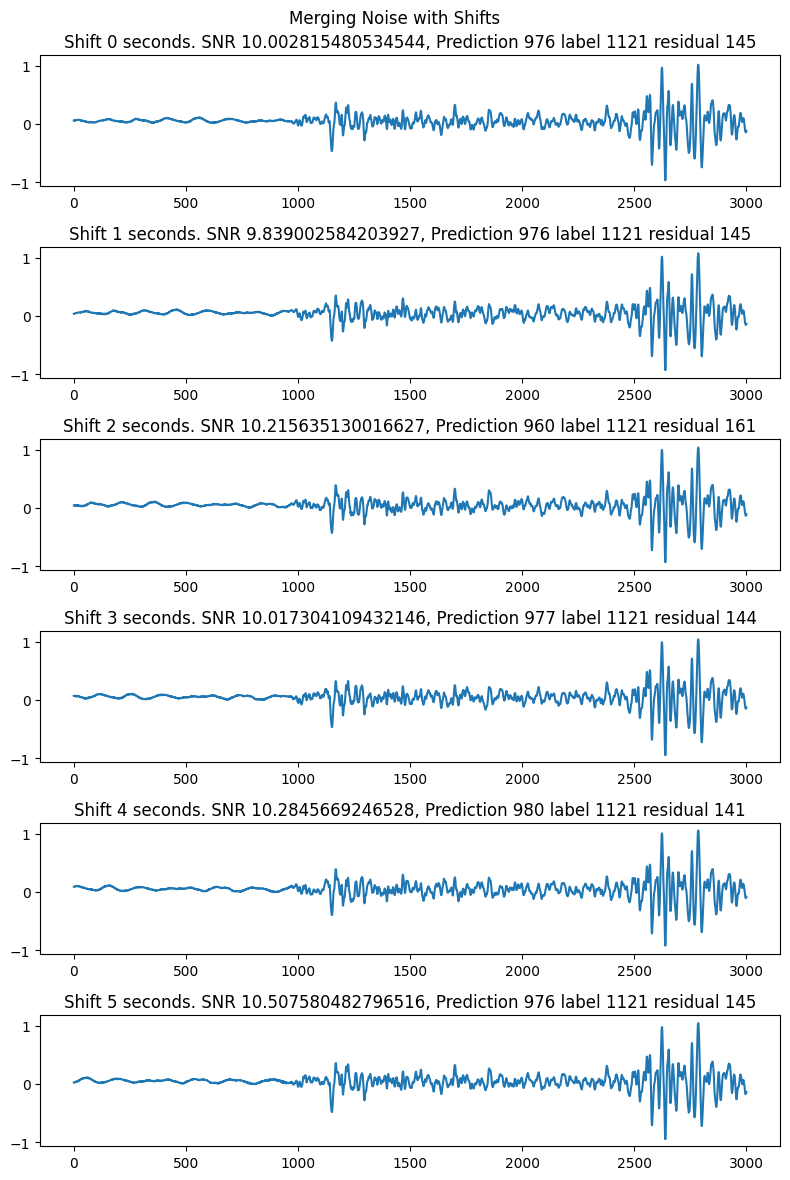

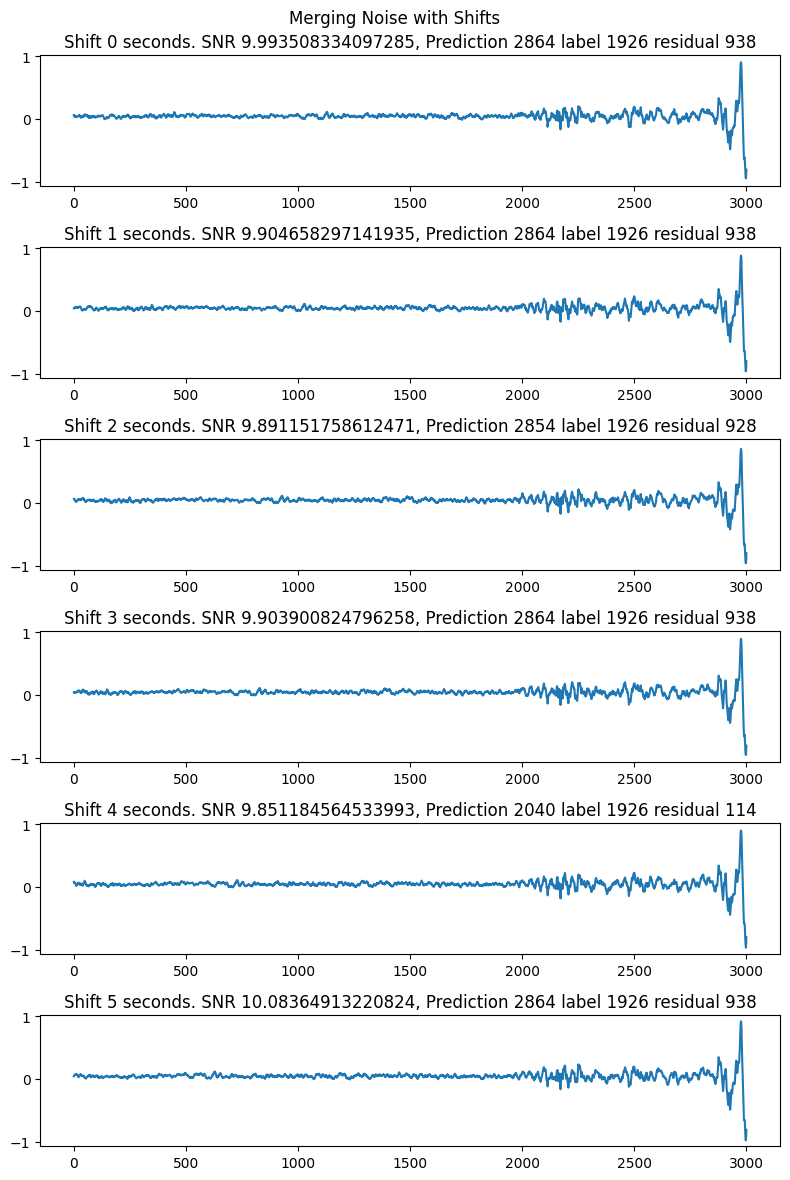

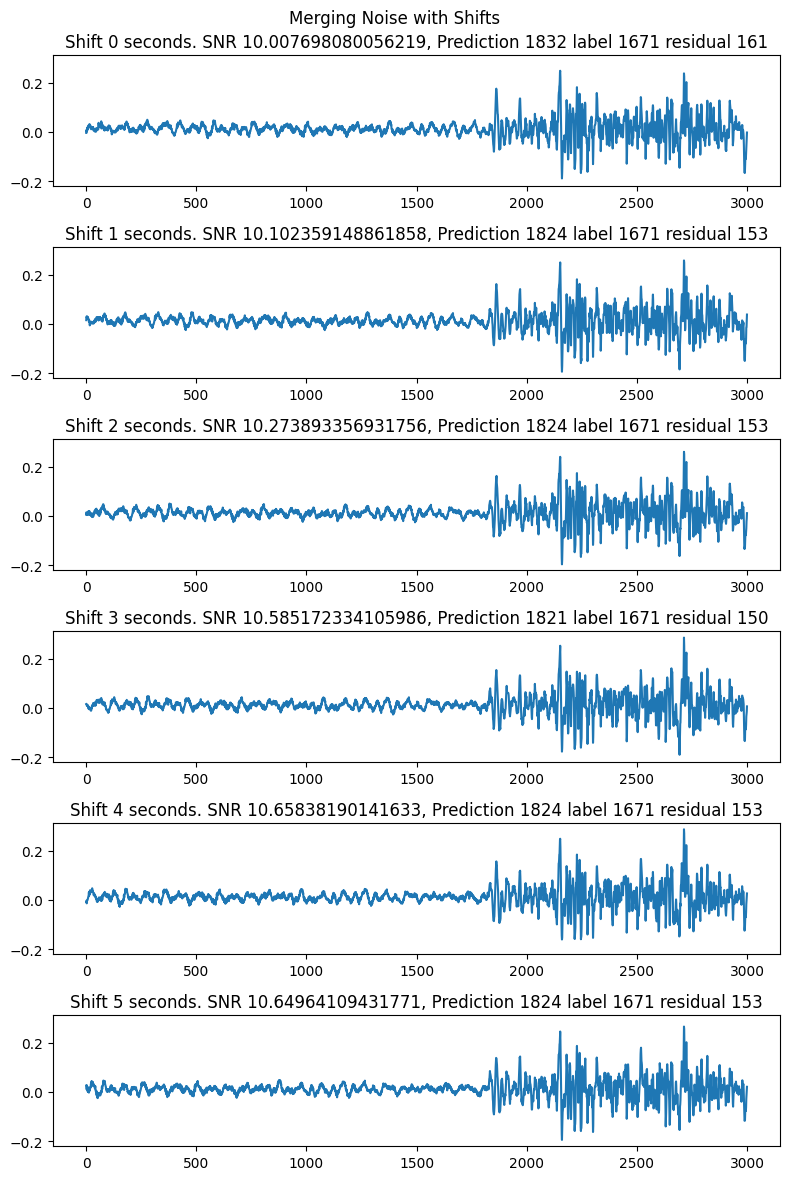

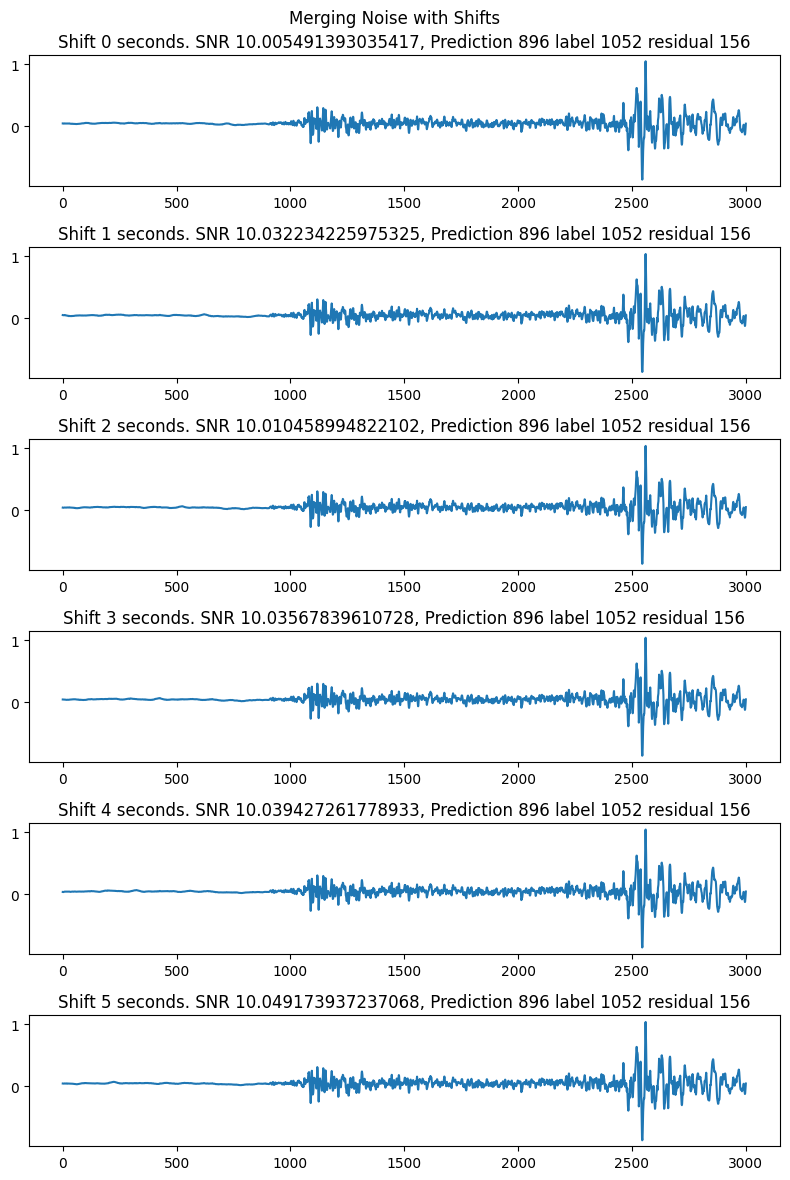

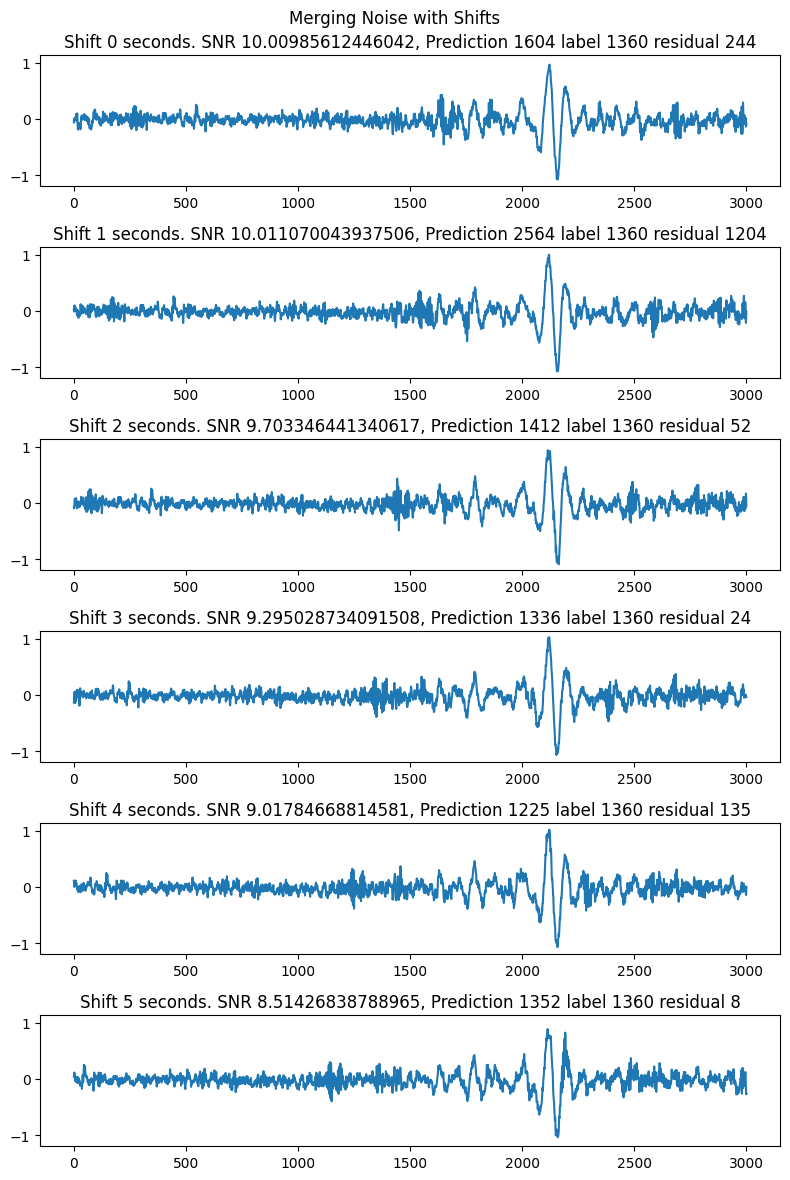

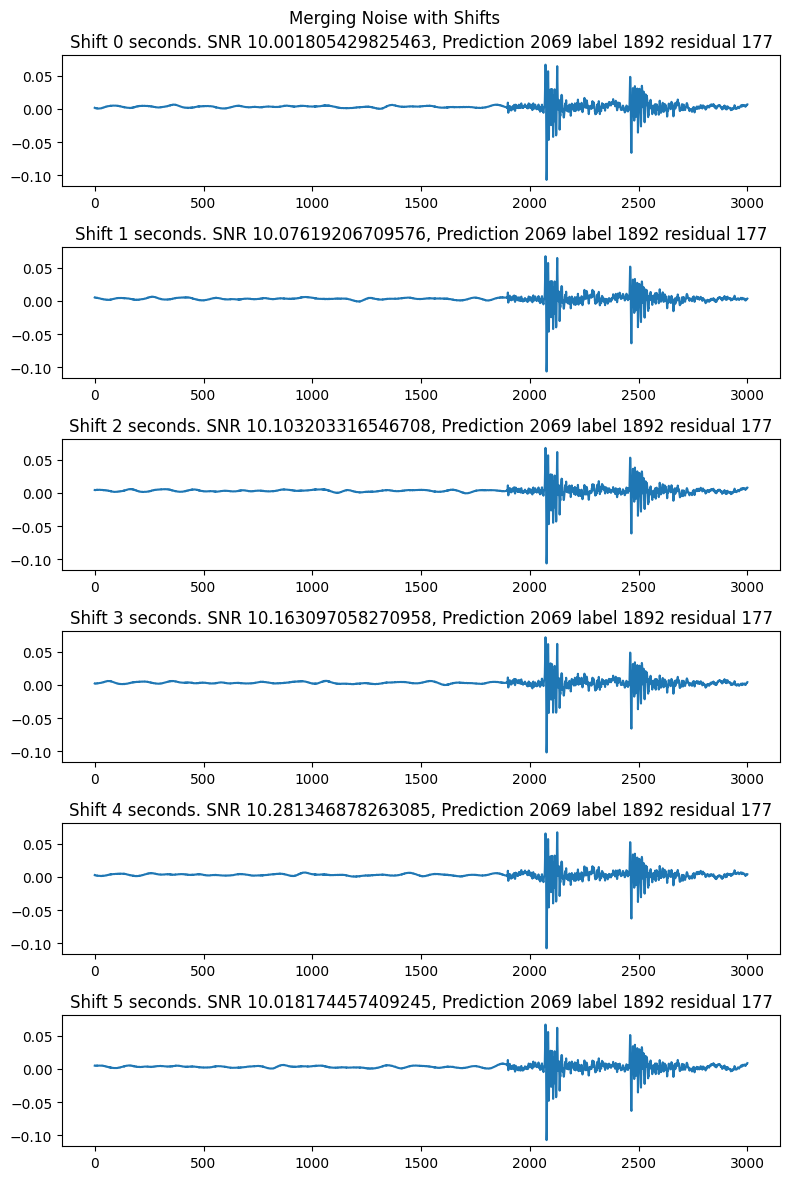

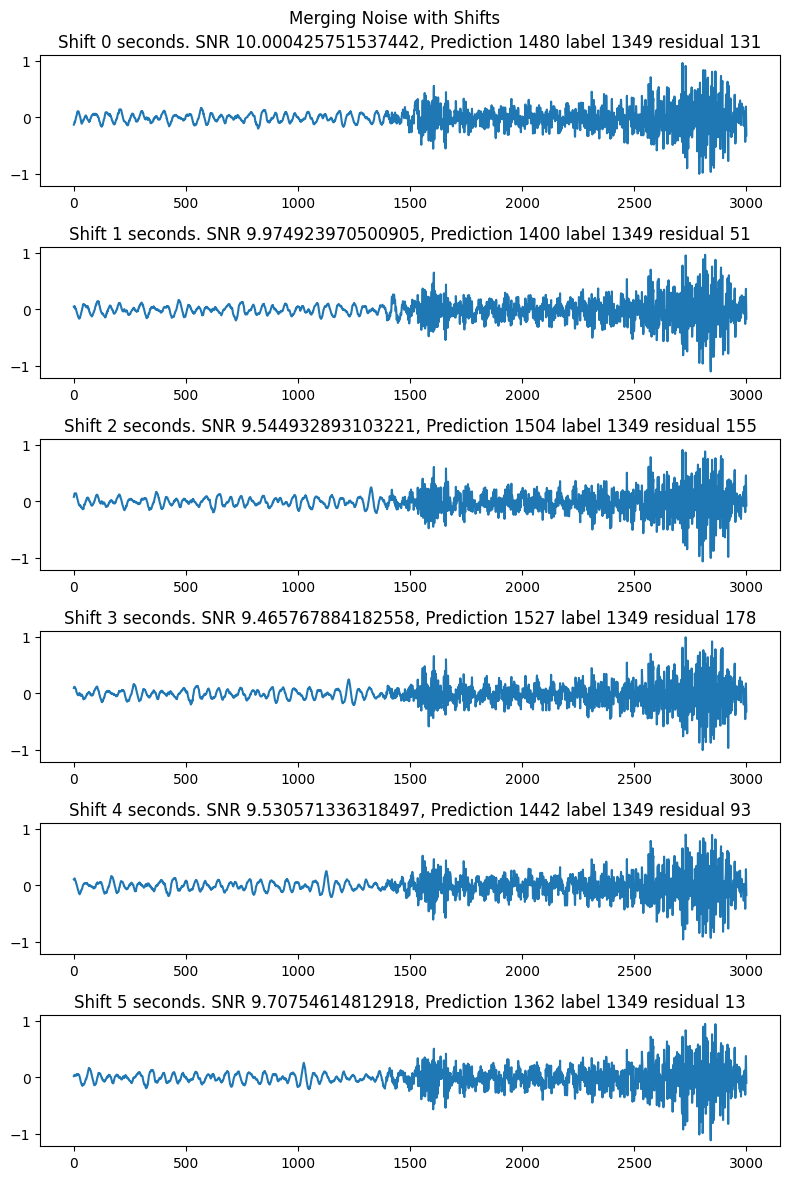

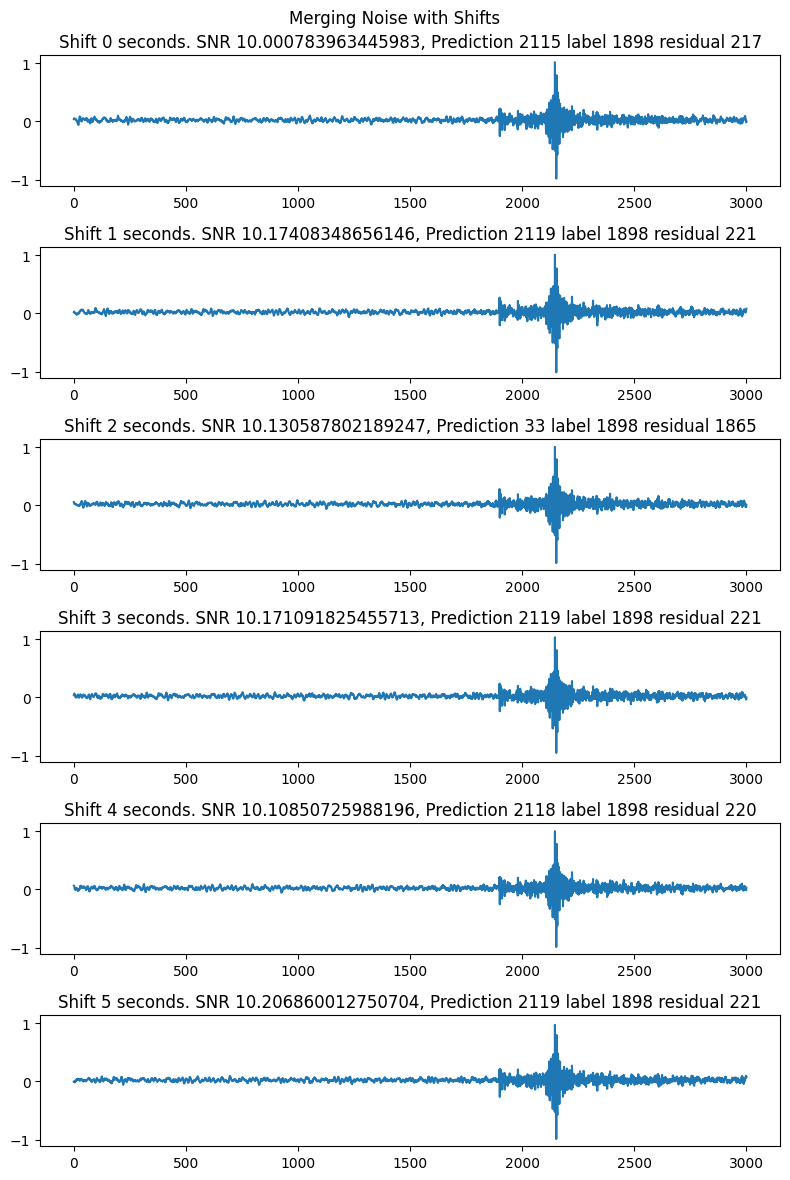

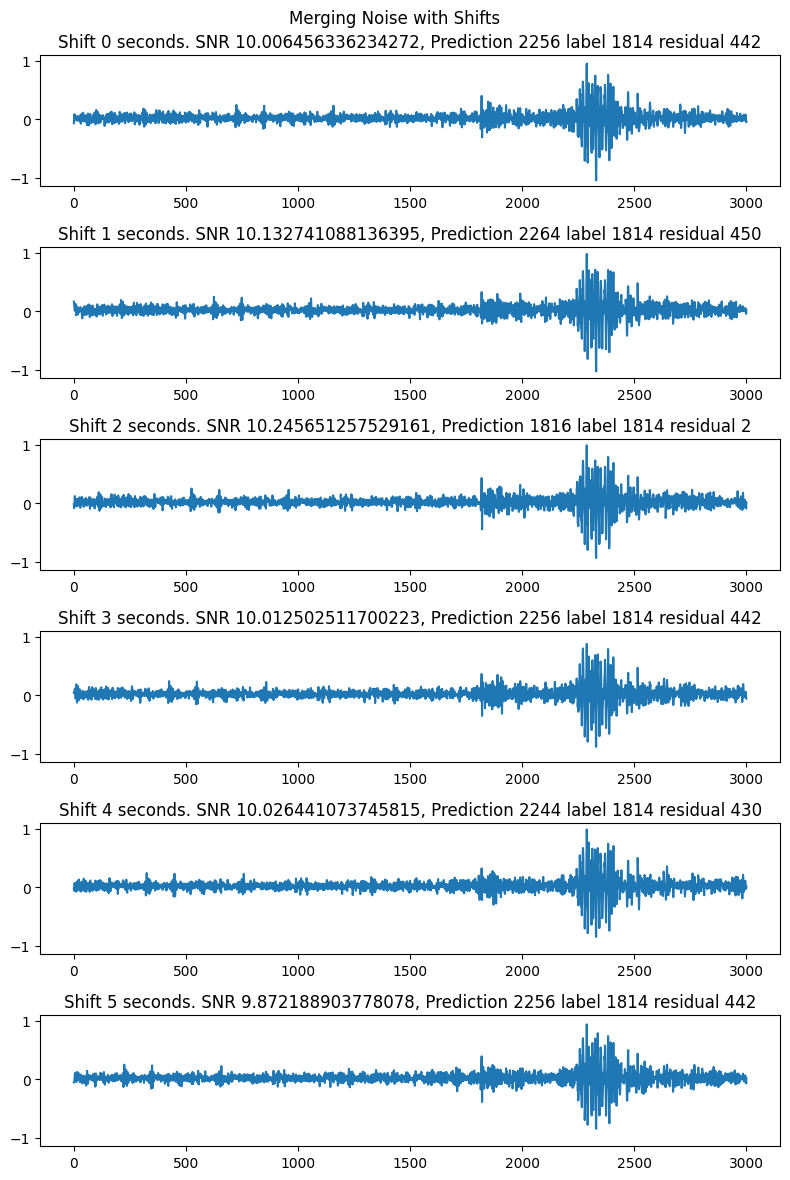

In [8]:
for trace, full_noise_trace, label in zip(le_dataset, le_noises_full, le_labels):
    shifting_experiment(trace=trace, full_noise_trace=full_noise_trace, label=int(label), \
         model=pretrained_model, num_shifts=NUM_SHIFTS, synthesized_snr=SYNTHESIZED_SNR, silent_prints=True, save_plot_to=SHIFTING_PLOTS_PATH)

## Filter the large error traces using FFT

lower_cut_off=12, upper_cut_off=100


/home/moshe/GIT/summer_2022_Seismology/experiments/filtering.py:22: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)
  filtered_prediction = predict(filtered.float(), model=model)
/home/moshe/miniconda3/envs/seis/lib/python3.10/site-packages/torch/_tensor.py:958: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


12 fixed
cut off [(12, 100), (12, 100)] fixed 12


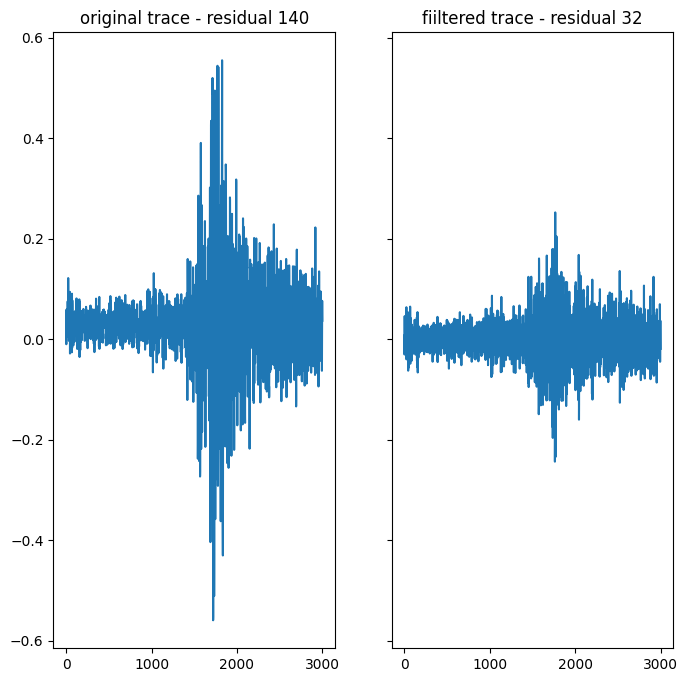

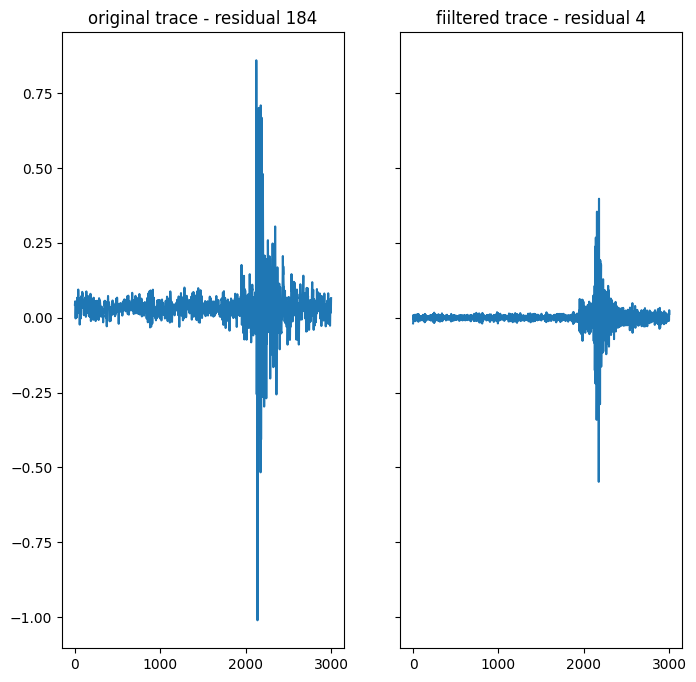

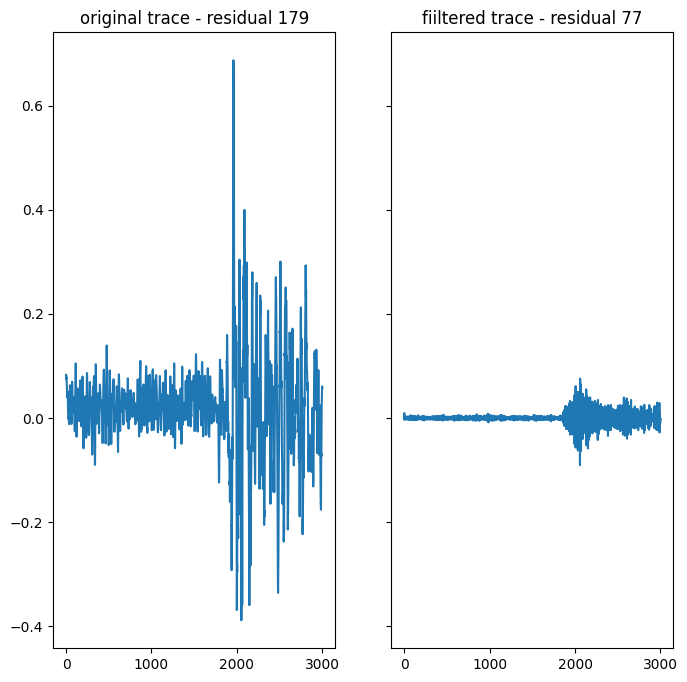

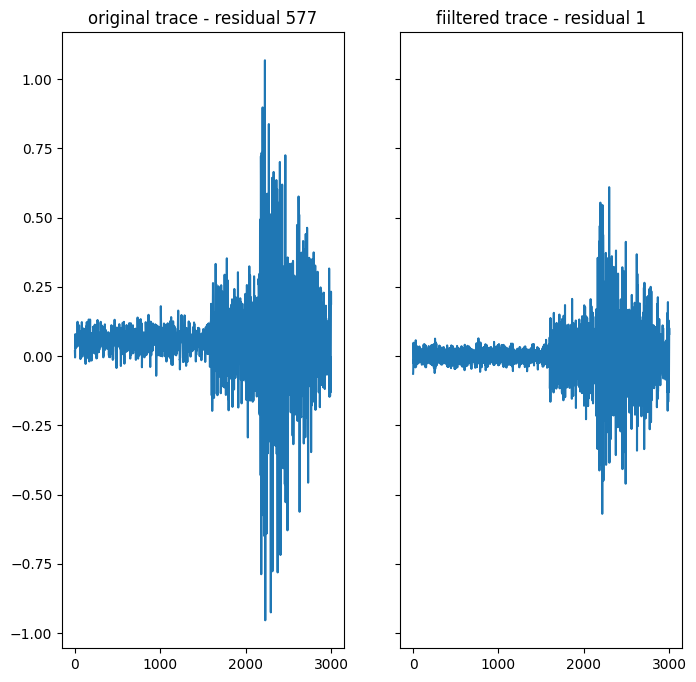

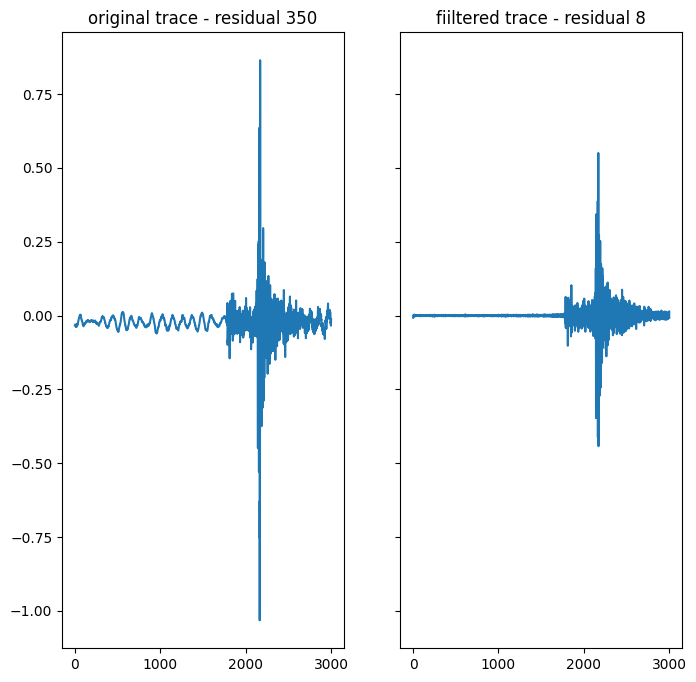

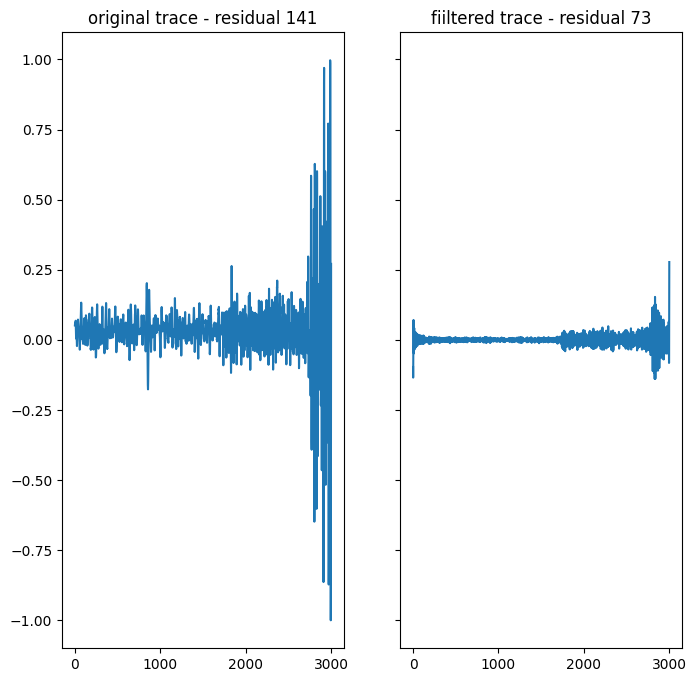

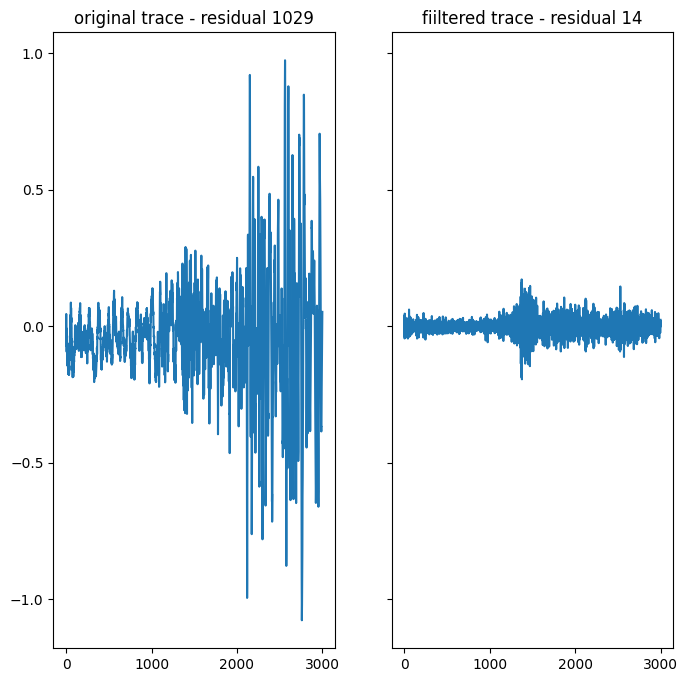

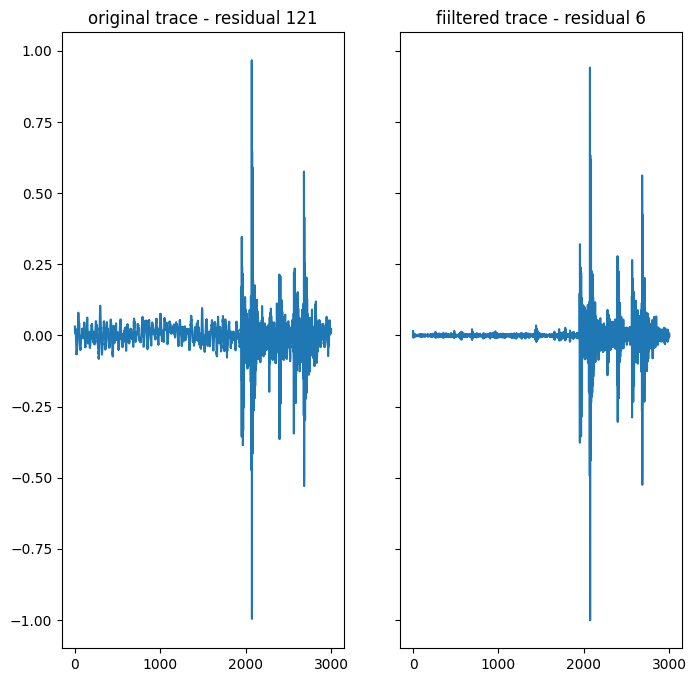

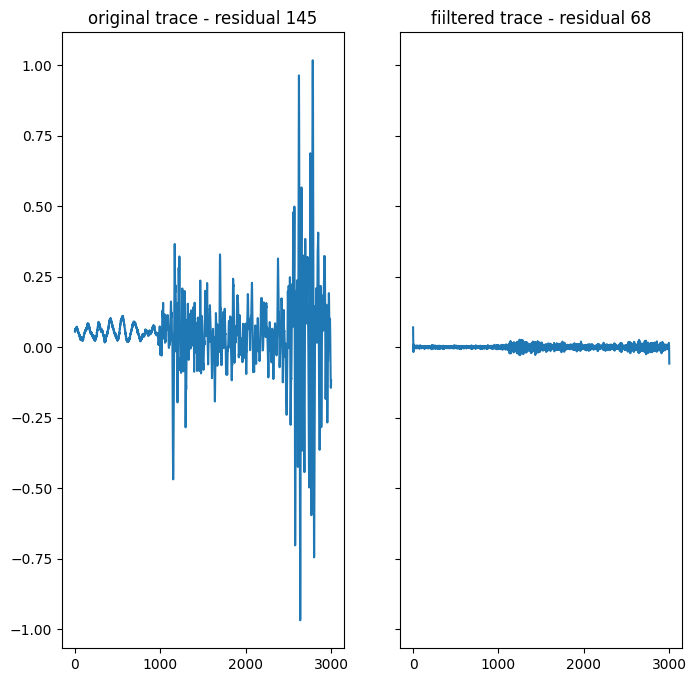

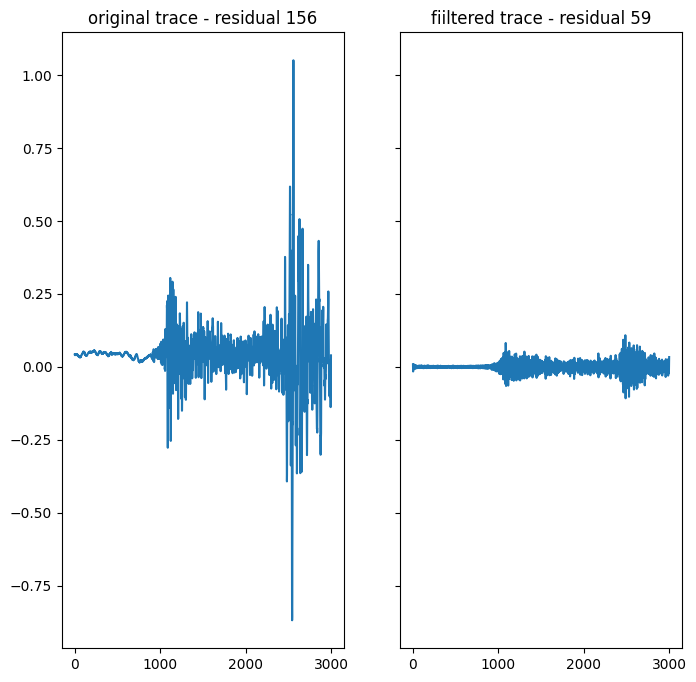

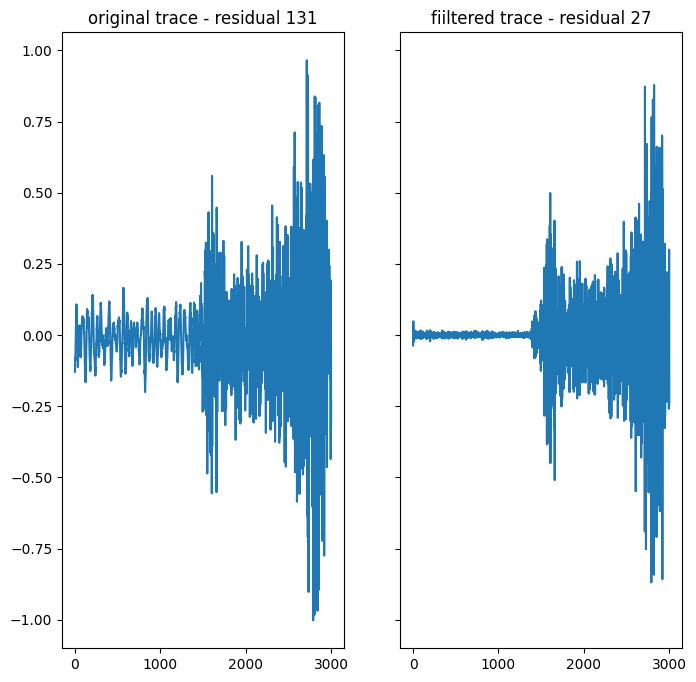

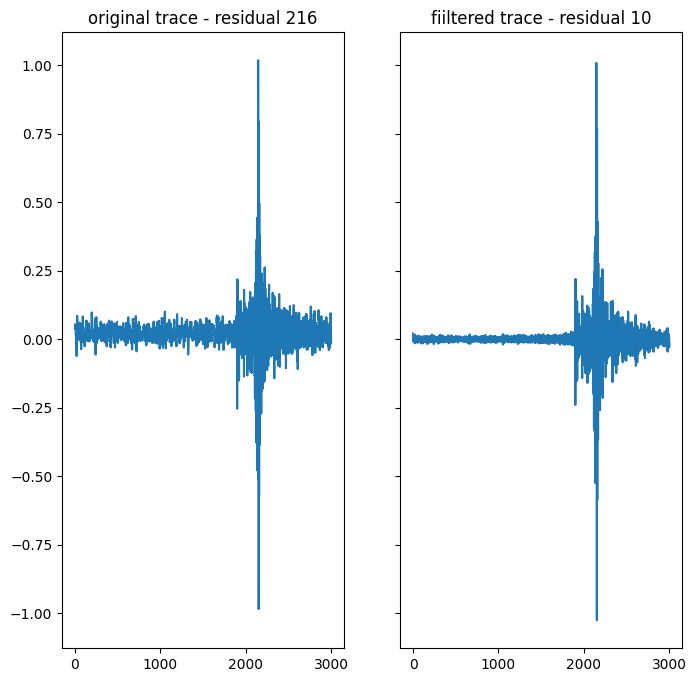

In [10]:
noised_traces_list = create_noisy_traces(calc_snr=CalcSNR(SnrCalcStrategy.ENERGY_RATIO), dataset=le_dataset, desired_snr=SYNTHESIZED_SNR, labels=le_labels, noise_traces=noises[large_error_traces_index_list])


def band_filter_experiment(lco, uco):
    print(f'lower_cut_off={lco}, upper_cut_off={uco}')
    fixed = fft_filter_experiment(traces_list=noised_traces_list, label_list=le_labels, model=pretrained_model,
                                  sample_rate=SAMPLE_RATE, residual_threshold_seconds=1, lower_cut_off=lco,
                                  upper_cut_off=uco, silent_prints=True, plot_fixed_traces=True)
    print(fixed, 'fixed')
    return fixed

def cut_off_search():
    max_fixed = 0
    best_lco_uco = []
    for lco in range(12, 13):
        for uco in range(100, 101):
            fixed = band_filter_experiment(lco, uco)
            if fixed > max_fixed:
                max_fixed = fixed
                best_lco_uco = [(lco, uco)]
            if fixed == max_fixed:
                best_lco_uco.append((lco, uco))
    print(f'cut off {best_lco_uco} fixed {max_fixed}')

cut_off_search()

lower_cut_off=5, upper_cut_off=100
5 fixed


5

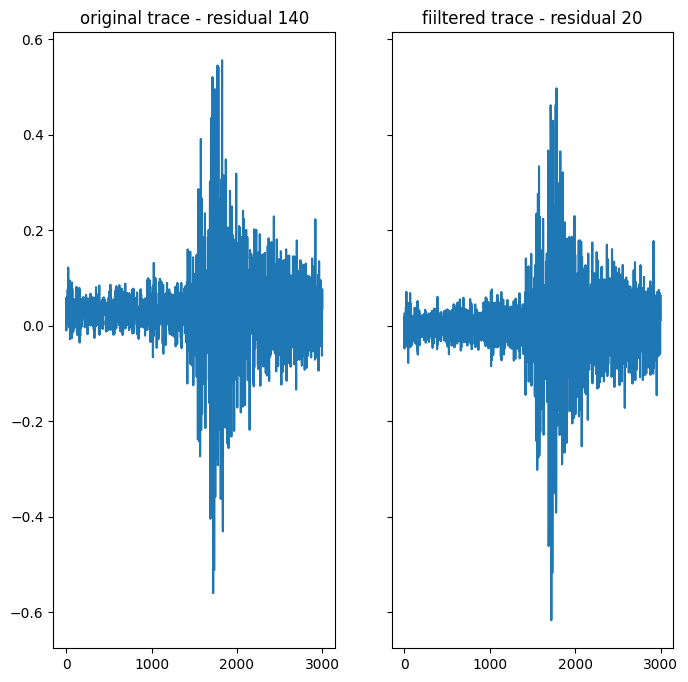

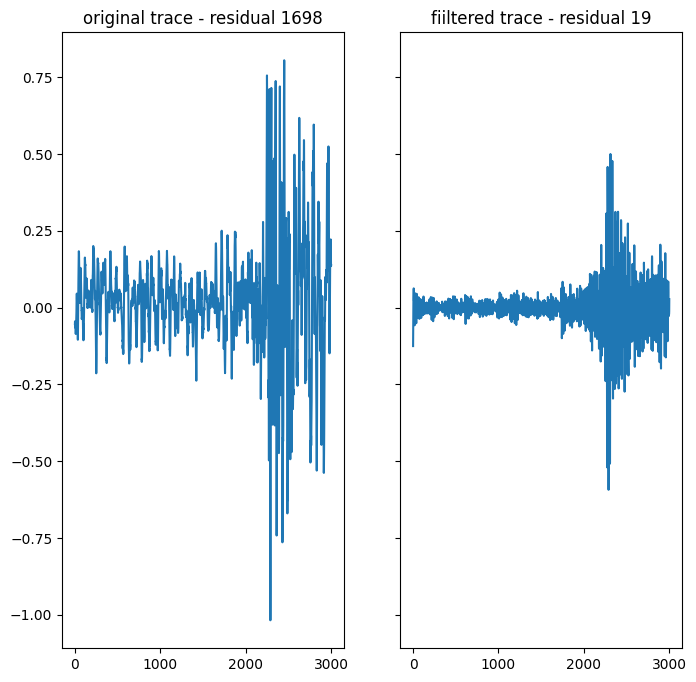

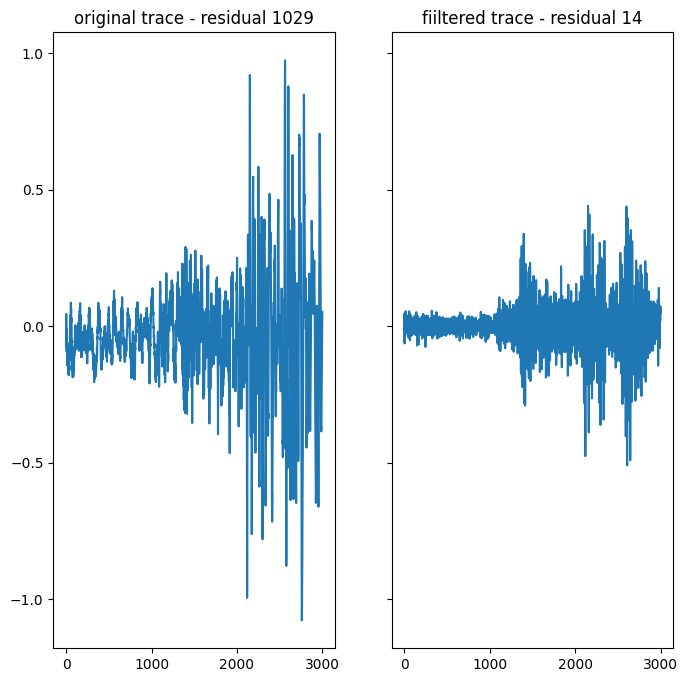

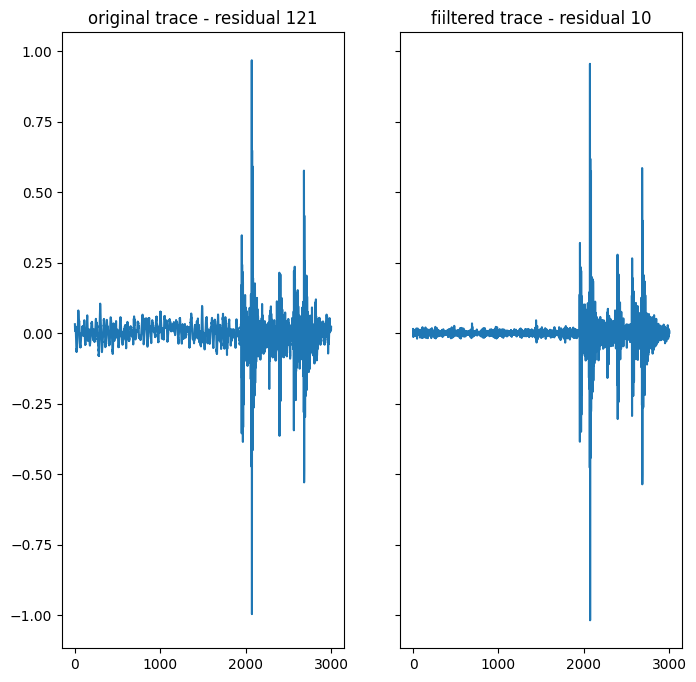

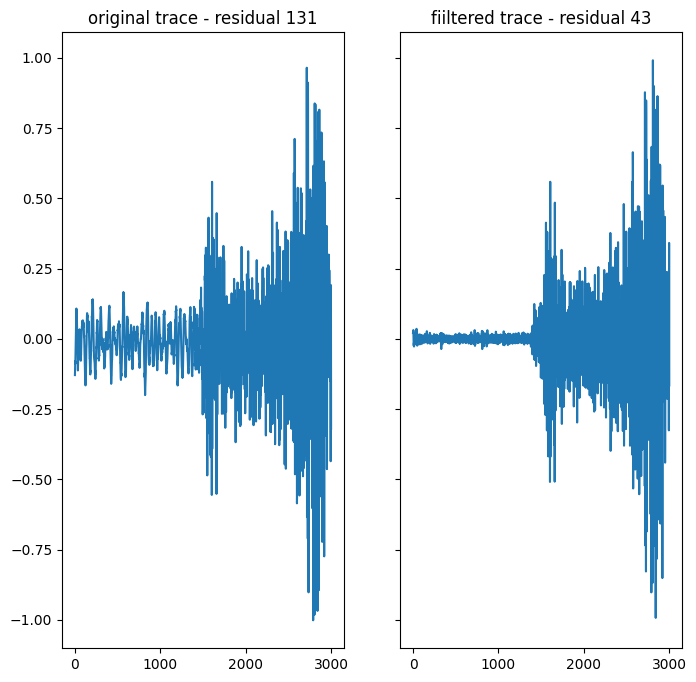

In [11]:
band_filter_experiment(lco=5, uco=100)